In [5]:
# 单元格1：导入库和设置路径
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import ast

# 设置路径
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))
ROOT_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw')
OUTPUT_DIR = os.path.join(ROOT_DIR, 'outputs', 'kua')

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"根目录: {ROOT_DIR}")
print(f"输出目录: {OUTPUT_DIR}")

根目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis
输出目录: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua


In [6]:
# 单元格2：数据加载函数
def check_file(path):
    """检查文件是否存在并加载"""
    full_path = os.path.join(DATA_DIR, os.path.basename(path))
    if os.path.exists(full_path):
        df = pd.read_csv(full_path)
        print(f"✅ {os.path.basename(path)}: {df.shape}")
        return df
    else:
        print(f"❌ {full_path}")
        return None

# 加载数据
df = check_file('data_with_citing.csv')
top10_data = check_file('top10_journals_data.csv')

✅ data_with_citing.csv: (13709, 10)
✅ top10_journals_data.csv: (9747, 10)


In [7]:
# 单元格3：数据预处理
df['citing'] = df['citing'].fillna('')

def safe_literal_eval(x):
    """安全地将字符串转换为列表"""
    if pd.isna(x) or x == '' or x == '[]':
        return []
    try:
        return ast.literal_eval(x)
    except:
        if isinstance(x, str):
            x_clean = x.strip('[]').replace("'", "").replace('"', '')
            items = [item.strip() for item in x_clean.split(',') if item.strip()]
            return items
        return []

df['citing'] = df['citing'].apply(safe_literal_eval)

# 获取Top10期刊列表并过滤数据
top10_journals = top10_data['Source Title'].unique().tolist()
df_top10 = df[df['Source Title'].isin(top10_journals)].copy()
print(f"过滤后: {df_top10.shape[0]}篇论文")

过滤后: 9747篇论文


In [8]:
# 单元格4：建立学科映射
doi_to_category_map = {}

for _, row in top10_data.iterrows():
    doi = str(row.get('DOI', '')).strip()
    category = row.get('WoS Categories', '')
    
    if doi and doi.lower() != 'nan' and pd.notna(category):
        # 标准化DOI格式
        if doi.startswith('https://doi.org/'):
            doi = doi.replace('https://doi.org/', '')
        elif doi.startswith('http://doi.org/'):
            doi = doi.replace('http://doi.org/', '')
        elif doi.startswith('doi:'):
            doi = doi.replace('doi:', '')
        
        doi_to_category_map[doi] = str(category).strip()

print(f"学科映射: {len(doi_to_category_map)}个")

学科映射: 9278个


In [9]:
# 单元格5：学科处理函数
def doi_to_categories(doi):
    """根据DOI返回学科列表"""
    if not doi or pd.isna(doi):
        return []
    
    doi_str = str(doi).strip()
    # 标准化DOI格式
    if doi_str.startswith('https://doi.org/'):
        doi_str = doi_str.replace('https://doi.org/', '')
    elif doi_str.startswith('http://doi.org/'):
        doi_str = doi_str.replace('http://doi.org/', '')
    elif doi_str.startswith('doi:'):
        doi_str = doi_str.replace('doi:', '')
    
    category = doi_to_category_map.get(doi_str)
    return [category] if category else []

def get_reference_categories_with_frequency(doi_list):
    """获取包含频率的学科列表"""
    if not doi_list:
        return []
    
    all_categories = []
    for doi in doi_list:
        categories = doi_to_categories(doi)
        all_categories.extend(categories)
    
    return all_categories

def get_reference_categories(doi_list):
    """获取去重的学科列表"""
    if not doi_list:
        return []
    
    all_categories = []
    for doi in doi_list:
        categories = doi_to_categories(doi)
        all_categories.extend(categories)
    
    return list(set(all_categories))

In [10]:
# 单元格6：构建共现矩阵
def build_co_occurrence_matrix(df):
    all_categories = set()
    for doi_list in df['citing']:
        categories = get_reference_categories(doi_list)
        all_categories.update(categories)
    
    all_categories = sorted(list(all_categories))
    n_categories = len(all_categories)
    category_index = {cat: idx for idx, cat in enumerate(all_categories)}
    
    co_occurrence = np.zeros((n_categories, n_categories))
    
    for doi_list in df['citing']:
        categories = get_reference_categories(doi_list)
        for i in range(len(categories)):
            idx_i = category_index[categories[i]]
            co_occurrence[idx_i, idx_i] += 1
            
            for j in range(i + 1, len(categories)):
                idx_j = category_index[categories[j]]
                co_occurrence[idx_i, idx_j] += 1
                co_occurrence[idx_j, idx_i] += 1
    
    return co_occurrence, all_categories

In [11]:
# 单元格7：计算Salton相似性矩阵
def calculate_salton_similarity(co_occurrence_matrix):
    n = co_occurrence_matrix.shape[0]
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                numerator = 0.0
                for k in range(n):
                    numerator += co_occurrence_matrix[i, k] * co_occurrence_matrix[j, k]
                
                denominator_i = np.sqrt(np.sum(co_occurrence_matrix[i, :]**2))
                denominator_j = np.sqrt(np.sum(co_occurrence_matrix[j, :]**2))
                denominator = denominator_i * denominator_j
                
                if denominator > 0:
                    similarity_matrix[i, j] = numerator / denominator
                else:
                    similarity_matrix[i, j] = 0.0
    
    return similarity_matrix

In [12]:
# 单元格8：计算单篇论文TD
def calculate_td_for_paper(paper_categories, similarity_matrix, all_categories):
    if not paper_categories:
        return 1.0
    
    category_index = {cat: idx for idx, cat in enumerate(all_categories)}
    
    category_counts = {}
    for cat in paper_categories:
        category_counts[cat] = category_counts.get(cat, 0) + 1
    
    total_refs = len(paper_categories)
    p_vector = np.zeros(len(all_categories))
    
    for cat, count in category_counts.items():
        if cat in category_index:
            idx = category_index[cat]
            p_vector[idx] = count / total_refs
    
    sum_term = 0.0
    for i in range(len(all_categories)):
        for j in range(len(all_categories)):
            sum_term += similarity_matrix[i, j] * p_vector[i] * p_vector[j]
    
    if sum_term > 0:
        return 1.0 / sum_term
    else:
        return 1.0

In [13]:
# 单元格9：主计算函数
def calculate_interdisciplinarity(df):
    print("构建学科共现矩阵...")
    co_occurrence, all_categories = build_co_occurrence_matrix(df)
    print(f"学科数: {len(all_categories)}")
    
    print("计算相似性矩阵...")
    similarity_matrix = calculate_salton_similarity(co_occurrence)
    
    print("计算论文TD...")
    td_scores = []
    
    for idx, row in df.iterrows():
        paper_categories = get_reference_categories_with_frequency(row['citing'])
        td_score = calculate_td_for_paper(paper_categories, similarity_matrix, all_categories)
        td_scores.append(td_score)
    
    df['TD_Score'] = td_scores
    journal_td = df.groupby('Source Title')['TD_Score'].mean().sort_values(ascending=False)
    
    return df, similarity_matrix, all_categories, journal_td

# 执行计算
df_with_td, similarity_matrix, all_categories, journal_td = calculate_interdisciplinarity(df_top10)

构建学科共现矩阵...
学科数: 1
计算相似性矩阵...
计算论文TD...


In [14]:
# 单元格10：保存结果到输出目录
print(f"保存结果到: {OUTPUT_DIR}")

# 1. 保存期刊TD得分
journal_td_df = journal_td.reset_index()
journal_td_df.columns = ['Journal', 'TD_Score']
journal_td_df['TD_Score'] = journal_td_df['TD_Score'].round(4)

journal_output_path = os.path.join(OUTPUT_DIR, 'journal_td_scores.csv')
journal_td_df.to_csv(journal_output_path, index=False, encoding='utf-8-sig')
print(f"✅ 期刊TD得分已保存: {journal_output_path}")

# 2. 保存每篇论文的TD得分
paper_output_path = os.path.join(OUTPUT_DIR, 'paper_td_scores.csv')
# 只保存必要的列
paper_results = df_with_td[['Source Title', 'DOI', 'TD_Score']].copy()
paper_results['TD_Score'] = paper_results['TD_Score'].round(4)
paper_results.to_csv(paper_output_path, index=False, encoding='utf-8-sig')
print(f"✅ 论文TD得分已保存: {paper_output_path}")

# 3. 保存学科相似性矩阵
similarity_output_path = os.path.join(OUTPUT_DIR, 'similarity_matrix.csv')
similarity_df = pd.DataFrame(similarity_matrix, index=all_categories, columns=all_categories)
similarity_df.to_csv(similarity_output_path, encoding='utf-8-sig')
print(f"✅ 学科相似性矩阵已保存: {similarity_output_path}")

# 4. 保存学科列表
categories_output_path = os.path.join(OUTPUT_DIR, 'categories_list.csv')
categories_df = pd.DataFrame({'Category': all_categories})
categories_df.to_csv(categories_output_path, index=False, encoding='utf-8-sig')
print(f"✅ 学科列表已保存: {categories_output_path}")

保存结果到: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua
✅ 期刊TD得分已保存: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua\journal_td_scores.csv
✅ 论文TD得分已保存: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua\paper_td_scores.csv
✅ 学科相似性矩阵已保存: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua\similarity_matrix.csv
✅ 学科列表已保存: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua\categories_list.csv


In [ ]:
# 单元格11：显示结果
print("=" * 60)
print("各期刊跨学科性(TD)得分:")
print("=" * 60)
for idx, row in journal_td_df.iterrows():
    print(f"{row['Journal']:<50} {row['TD_Score']:.4f}")

print(f"\n所有结果已保存到: {OUTPUT_DIR}")
print(f"文件列表:")
print(f"  - journal_td_scores.csv (期刊得分)")
print(f"  - paper_td_scores.csv (论文得分)")
print(f"  - similarity_matrix.csv (相似性矩阵)")
print(f"  - categories_list.csv (学科列表)")

各期刊跨学科性(TD)得分:
ANNALS OF BIOMEDICAL ENGINEERING                   1.0000
BIOMEDICAL ENGINEERING ONLINE                      1.0000
BIOMEDICAL SIGNAL PROCESSING AND CONTROL           1.0000
EXPERT REVIEW OF MEDICAL DEVICES                   1.0000
IEEE PULSE                                         1.0000
IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING        1.0000
JOURNAL OF MEDICAL AND BIOLOGICAL ENGINEERING      1.0000
JOURNAL OF MEDICAL DEVICES-TRANSACTIONS OF THE ASME 1.0000
MEDICAL ENGINEERING & PHYSICS                      1.0000
NATURE BIOMEDICAL ENGINEERING                      1.0000

✅ 所有结果已保存到: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua
📁 文件列表:
  - journal_td_scores.csv (期刊得分)
  - paper_td_scores.csv (论文得分)
  - similarity_matrix.csv (相似性矩阵)
  - categories_list.csv (学科列表)


✅ 图表已保存: c:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\outputs\kua\journal_td_chart.png


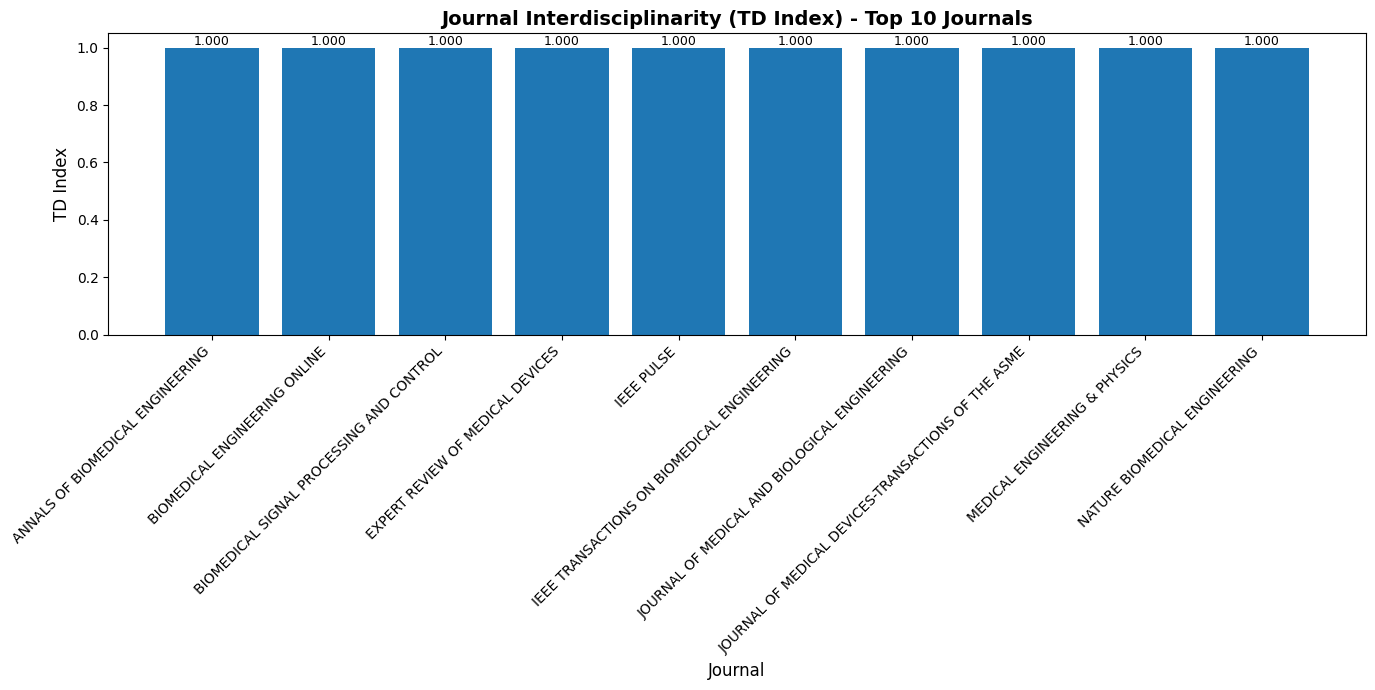

In [16]:
# 单元格12：可视化
plt.figure(figsize=(14, 7))
bars = plt.bar(journal_td.index, journal_td.values)
plt.title('Journal Interdisciplinarity (TD Index) - Top 10 Journals', fontsize=14, fontweight='bold')
plt.xlabel('Journal', fontsize=12)
plt.ylabel('TD Index', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# 在每个柱子上添加数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# 保存图表
chart_output_path = os.path.join(OUTPUT_DIR, 'journal_td_chart.png')
plt.savefig(chart_output_path, dpi=300, bbox_inches='tight')
print(f"✅ 图表已保存: {chart_output_path}")

plt.show()